<a href="https://colab.research.google.com/github/grigorjevas/Discogs-marketplace-scraper/blob/main/Preparing_data_and_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Discogs Marketplace price predictions

## EDA and selecting data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import pickle

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Data/electro_raw_data.csv", parse_dates=["release_date"], na_values="N/A")

In [4]:
df.head()

,artist,title,label,release_format,number_of_tracks,release_date,price,rating,votes,have,want,limited_edition,media_condition,sleeve_condition,release_page
0,Quintron And Miss Pussycat,Live At Third Man Records,Third Man Records ‎– TMR 147,LP,10,2012-03-12,19.00,5.00,1.0,9,10,0,Mint (M),Mint (M),https://discogs.com/Quintron-And-Miss-Pussycat...
1,Jean-Michel Jarre,The Concerts In China,"PGP RTB ‎– 3220117, Polydor ‎– DLP 2612 039",LP,15,1982-01-01,21.27,4.00,23.0,204,53,0,Very Good Plus (VG+),Very Good (VG),https://discogs.com/Jean-Michel-Jarre-The-Conc...
2,MC T-Rock,Introducing,M-Pire Records ‎– MPR 9901.4,"12""",4,1999-01-01,21.34,4.42,24.0,107,78,0,Very Good Plus (VG+),Generic,https://discogs.com/MC-T-Rock-Introducing/rele...
3,E.T.M.S.,Sounds Of Humanoid Kind,Musix Records ‎– SMX 11004,"12""",13,1983-01-01,24.19,4.40,72.0,256,267,1,Very Good Plus (VG+),Very Good Plus (VG+),https://discogs.com/ETMS-Sounds-Of-Humanoid-Ki...
4,The Art Of Noise,In Visible Silence,"Chrysalis ‎– BFV 41528, China Records ‎– BFV 4...",LP,11,1986-01-01,24.14,4.01,109.0,896,123,0,Very Good Plus (VG+),Very Good Plus (VG+),https://discogs.com/The-Art-Of-Noise-In-Visibl...


In [5]:
df.shape

(4998, 15)

Convert release date to year

In [6]:
df["release_year"] = df['release_date'].dt.year

Parse item condition to numerical values

In [7]:
# Parses item condition value to numerical values
def parse_item_condition_to_int(condition: str) -> int:
    return {
        "Poor (P)": 0,
        "Fair (F)": 0,
        "Good (G)": 1,
        "Good Plus (G+)": 1,
        "Very Good (VG)": 2,
        "Very Good Plus (VG+)": 3,
        "Generic": 3,
        "Not Graded": 3,
        "No Cover": 3,
        "Near Mint (NM or M-)": 4,
        "Mint (M)": 5
    }[condition]

In [8]:
df["media_condition"] = df["media_condition"].apply(
    lambda cond: parse_item_condition_to_int(cond))
df["sleeve_condition"] = df["sleeve_condition"].apply(
    lambda cond: parse_item_condition_to_int(cond))

Drop N/A rows 

In [9]:
df = df.dropna()

Drop unneeded columns

In [10]:
df = df.drop(["label", "release_date", "release_page"], axis="columns")

In [11]:
df.head()

,artist,title,release_format,number_of_tracks,price,rating,votes,have,want,limited_edition,media_condition,sleeve_condition,release_year
0,Quintron And Miss Pussycat,Live At Third Man Records,LP,10,19.00,5.00,1.0,9,10,0,5,5,2012.0
1,Jean-Michel Jarre,The Concerts In China,LP,15,21.27,4.00,23.0,204,53,0,3,2,1982.0
2,MC T-Rock,Introducing,"12""",4,21.34,4.42,24.0,107,78,0,3,3,1999.0
3,E.T.M.S.,Sounds Of Humanoid Kind,"12""",13,24.19,4.40,72.0,256,267,1,3,3,1983.0
4,The Art Of Noise,In Visible Silence,LP,11,24.14,4.01,109.0,896,123,0,3,3,1986.0


In [12]:
df.shape

(4841, 13)

## Encoding and scaling data 

In [13]:
one_hot_encoder = OneHotEncoder().fit(df[["release_format"]])

In [14]:
encoded_data = one_hot_encoder.transform(df[["release_format"]]).todense()

In [15]:
scaler = StandardScaler().fit(
    df.drop(["artist", "title", "release_format", "price"], axis="columns"))

In [16]:
scaled_data = scaler.transform(
    df.drop(["artist", "title", "release_format", "price"], axis="columns"))

In [17]:
encoded_features = np.concatenate([encoded_data, scaled_data], axis=-1)

In [18]:
train_features, test_features, train_price, test_price = train_test_split(
    encoded_features, df["price"]
)

Training the model

In [19]:
model = LinearRegression(fit_intercept=False)
model.fit(train_features, train_price)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

Evaluating the model

In [20]:
model.score(test_features, test_price)

0.4214885503087258

In [21]:
predicted = model.predict(test_features)

In [22]:
metrics.mean_absolute_error(test_price, predicted)

2.63883890994954

In [23]:
expected = test_price

Text(0, 0.5, 'Predicted price')

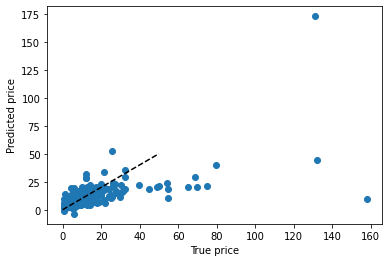

In [24]:
plt.scatter(expected, predicted)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')

Exporting the models

In [39]:
with open("model.pkl", "wb") as f:
  pickle.dump(model, f)

In [40]:
with open("one_hot_encoder.pkl", "wb") as f:
  pickle.dump(one_hot_encoder, f)

In [41]:
with open("scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)

In [26]:
# price 5.99
# artist = "Joors & DJ Stingray (2) ‎– The Nines"
# title = "The Nines"
test_df = pd.read_csv("/content/drive/MyDrive/Data/electro_test_data.csv", parse_dates=["release_date"], na_values="N/A")
test_df = test_df.dropna()

In [27]:
test_df["release_year"] = test_df['release_date'].dt.year
test_df["media_condition"] = test_df["media_condition"].apply(
    lambda cond: parse_item_condition_to_int(cond))
test_df["sleeve_condition"] = test_df["sleeve_condition"].apply(
    lambda cond: parse_item_condition_to_int(cond))

In [28]:
test_df = test_df.drop(["label", "release_date", "release_page"], axis="columns")

In [29]:
df.shape

(4841, 13)

In [30]:
df.drop(["artist", "title", "release_format", "price"], axis="columns").shape

(4841, 9)

In [31]:
test_df.shape

(10, 13)

In [32]:
test_df.drop(["artist", "title", "release_format", "price"], axis="columns").shape

(10, 9)

In [33]:
test_df

,artist,title,release_format,number_of_tracks,price,rating,votes,have,want,limited_edition,media_condition,sleeve_condition,release_year
0,Enigma,Sadeness Part I,"12""",4,5.99,4.22,49,358,203,0,4,3,1990
1,Peanut Butter Wolf,Chrome Children,LP,19,78.00,4.53,15,163,170,0,5,4,2006
2,B.M.O.C. (Big Man On Campus),Play That Funk,"12""",6,3.00,3.75,4,25,7,0,4,4,1988
3,Mirwais,Miss You,"12""",2,2.99,3.67,3,80,20,0,2,3,2002
4,World Class Wreckin' Cru,Phases In Life,LP,10,30.00,3.62,13,43,70,0,4,4,1990
5,L.A. Dream Team Featuring,Citizens On Patrol,"12""",2,10.00,4.27,11,62,28,0,4,4,1987
6,Antoinette,Burnin' At 20 Below,LP,11,26.00,3.88,16,118,88,0,4,4,1990
7,Various,Friday - Original Motion Picture Soundtrack,LP,15,187.00,4.49,39,395,479,0,5,4,1995
8,N.W.A. And The Posse,N.W.A. And The Posse,LP,11,94.00,4.42,62,595,239,0,4,4,1989
9,Solar System,City Of Angels,"12""",4,23.90,3.77,22,136,141,0,4,4,2000


In [34]:
encoded_test_data = one_hot_encoder.transform(test_df[["release_format"]]).todense()

In [35]:
scaled_test_data = scaler.transform(
    test_df.drop(["artist", "title", "release_format", "price"], axis="columns"))

In [36]:
encoded_test_features = np.concatenate([encoded_test_data, scaled_test_data], axis=-1)

In [37]:
encoded_test_features.shape

(10, 17)

In [38]:
model.predict(encoded_test_features)

array([ 9.3220456 , 27.32263876,  7.32185097,  5.16956785, 14.0877956 ,
        4.32729651, 15.62281567, 30.31284569, 17.83548013,  9.28673228])